# Data Loading

In [1]:
# Importing data science libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import dump

# Configure pandas setting
pd.set_option('display.max_columns', None)

# Loading all dataframes
df_cust = pd.read_csv('D:/[01] SKILLS/[00] Projects/02 Probability of Default (PD) Model/data/raw/customer_data.csv')
df_bureau = pd.read_csv('D:/[01] SKILLS/[00] Projects/02 Probability of Default (PD) Model/data/raw/bureau_data.csv')
df_loan = pd.read_csv('D:/[01] SKILLS/[00] Projects/02 Probability of Default (PD) Model/data/raw/loan_data.csv')

# Merge dataframes
df = df_cust.merge(right= df_bureau, on= 'cust_id').merge(right= df_loan, on= 'cust_id')

# Preview merged dataframes
df.head()

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,loan_id,loan_purpose,loan_type,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,disbursal_date,installment_start_dt,default
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,Delhi,110001,1,1,42,0,0,3,7,L00001,Auto,Secured,3004000,2467000,49340.0,444060,1973600,33,1630408,873386,2019-07-24,2019-08-10,False
1,C00002,38,M,Married,Salaried,1206000,3,Owned,4,Chennai,Tamil Nadu,600001,3,1,96,12,60,5,4,L00002,Home,Secured,4161000,3883000,77660.0,698940,3106400,30,709309,464100,2019-07-24,2019-08-15,False
2,C00003,46,F,Married,Self-Employed,2878000,3,Owned,24,Kolkata,West Bengal,700001,2,1,82,24,147,6,58,L00003,Personal,Unsecured,2401000,2170000,43400.0,390600,1736000,21,1562399,1476042,2019-07-24,2019-08-21,False
3,C00004,55,F,Single,Self-Employed,3547000,1,Owned,15,Bangalore,Karnataka,560001,3,0,115,15,87,5,26,L00004,Personal,Unsecured,2345000,1747000,34940.0,314460,1397600,6,1257839,1031094,2019-07-24,2019-08-09,False
4,C00005,37,M,Married,Salaried,3432000,3,Owned,28,Pune,Maharashtra,411001,4,2,120,0,0,5,10,L00005,Auto,Secured,4647000,4520000,90400.0,813600,3616000,28,1772334,1032458,2019-07-24,2019-08-02,False


# Data Quality Assessment

## Structural Quality

In [2]:
# Check for dataframe shape
print(f'No. of rows: {df.shape[0]:,}')
print(f'No. of cols: {df.shape[1]}')
print("="*75)

# Check for missing values
df_mv = pd.DataFrame(data={
    'no. of missing values' : df.isna().sum(),
    '% of missing values' : df.isna().sum() / df.shape[0] * 100
})
print('Missing value details:\n',df_mv[df_mv['no. of missing values'] > 0])
print("="*75)

# Check for duplicate records
print('No. of duplicate records:',df.duplicated().sum())

No. of rows: 50,000
No. of cols: 33
Missing value details:
                 no. of missing values  % of missing values
residence_type                     62                0.124


No. of duplicate records: 0


- 1 (residence_type) out of 33 columns has missing values (0.124), however we can impute them by using mode.
- there are no duplicate records, however we will apply drop duplicate method to handle future errors.

## Numeric Columns

In [3]:
num_cols = [
    'age',
    'income',
    'number_of_dependants',
    'years_at_current_address',
    'number_of_open_accounts',
    'number_of_closed_accounts',
    'total_loan_months',
    'delinquent_months',
    'total_dpd',
    'enquiry_count',
    'credit_utilization_ratio',
    'sanction_amount',
    'loan_amount',
    'processing_fee',
    'gst',
    'net_disbursement',
    'loan_tenure_months',
    'principal_outstanding',
    'bank_balance_at_application'
]
df[num_cols].describe().astype(int)

,age,income,number_of_dependants,years_at_current_address,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application
count,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000
mean,39,2640897,1,16,2,1,76,4,26,5,43,4704827,3999678,80494,719942,3199743,25,1337636,989126
std,9,2629441,1,8,1,0,43,5,32,2,29,6267276,5376552,117312,967779,4301241,12,1214713,1046071
min,18,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,6,-1,0
25%,33,803000,0,8,1,0,42,0,0,4,18,1147000,967000,19340,174060,773600,16,424799,287007
50%,40,1892000,2,16,3,1,71,3,14,5,39,2656000,2240000,44800,403200,1792000,24,1002309,668525
75%,46,3332250,3,24,4,2,107,9,46,6,67,5172250,4611000,92240,829980,3688800,35,1790751,1238667
max,70,11999000,5,31,4,2,223,24,171,9,99,52175000,47819000,5698029,8607420,38255200,59,5000000,7846643


- we can observe, monetary features i.e. income, sanction_amount, loan_amount, processing_fee, gst, net_disbursement, and bank_balance_at_application have minimum value of 0 which is not plausible.
- also, minimum value for principal_outstanding is negative which is implausible since it represents remaining loan amount (excluding interests) a borrower has to return.
- there is a possibility that the errors in monetary features is due anomaly in principal_outstanding. (further investigation is required)
- credit_utilization_ratio can be zero in a situation when individual has never used credit amount and only utilized amount from bank balance.

In [4]:
cols_to_investigate = ['principal_outstanding', 'income', 'sanction_amount', 'loan_amount', 'processing_fee', 'gst', 'net_disbursement', 'bank_balance_at_application']

# Investigating anomalies
print('No. of records with anomalies:')
print("="*35)

for col in cols_to_investigate:
    if col == 'principal_outstanding':
        print(f"{col:<27} : {df[df[col] == -1].shape[0]}")
    else:
        print(f"{col:<27} : {df[df[col] == 0].shape[0]}")

df[df['principal_outstanding'] == -1][cols_to_investigate]

No. of records with anomalies:
principal_outstanding       : 8
income                      : 8
sanction_amount             : 8
loan_amount                 : 8
processing_fee              : 8
gst                         : 8
net_disbursement            : 8
bank_balance_at_application : 8


,principal_outstanding,income,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,bank_balance_at_application
2278,-1,0,0,0,0.0,0,0,0
4950,-1,0,0,0,0.0,0,0,0
11092,-1,0,0,0,0.0,0,0,0
13356,-1,0,0,0,0.0,0,0,0
27457,-1,0,0,0,0.0,0,0,0
45224,-1,0,0,0,0.0,0,0,0
46640,-1,0,0,0,0.0,0,0,0
47428,-1,0,0,0,0.0,0,0,0


Our assumption was right regarding anomalies, however, this must be due to technical/systemic error with pipeline. We have to communicate data engineers and meanwhile we will setup anomaly handling methods.

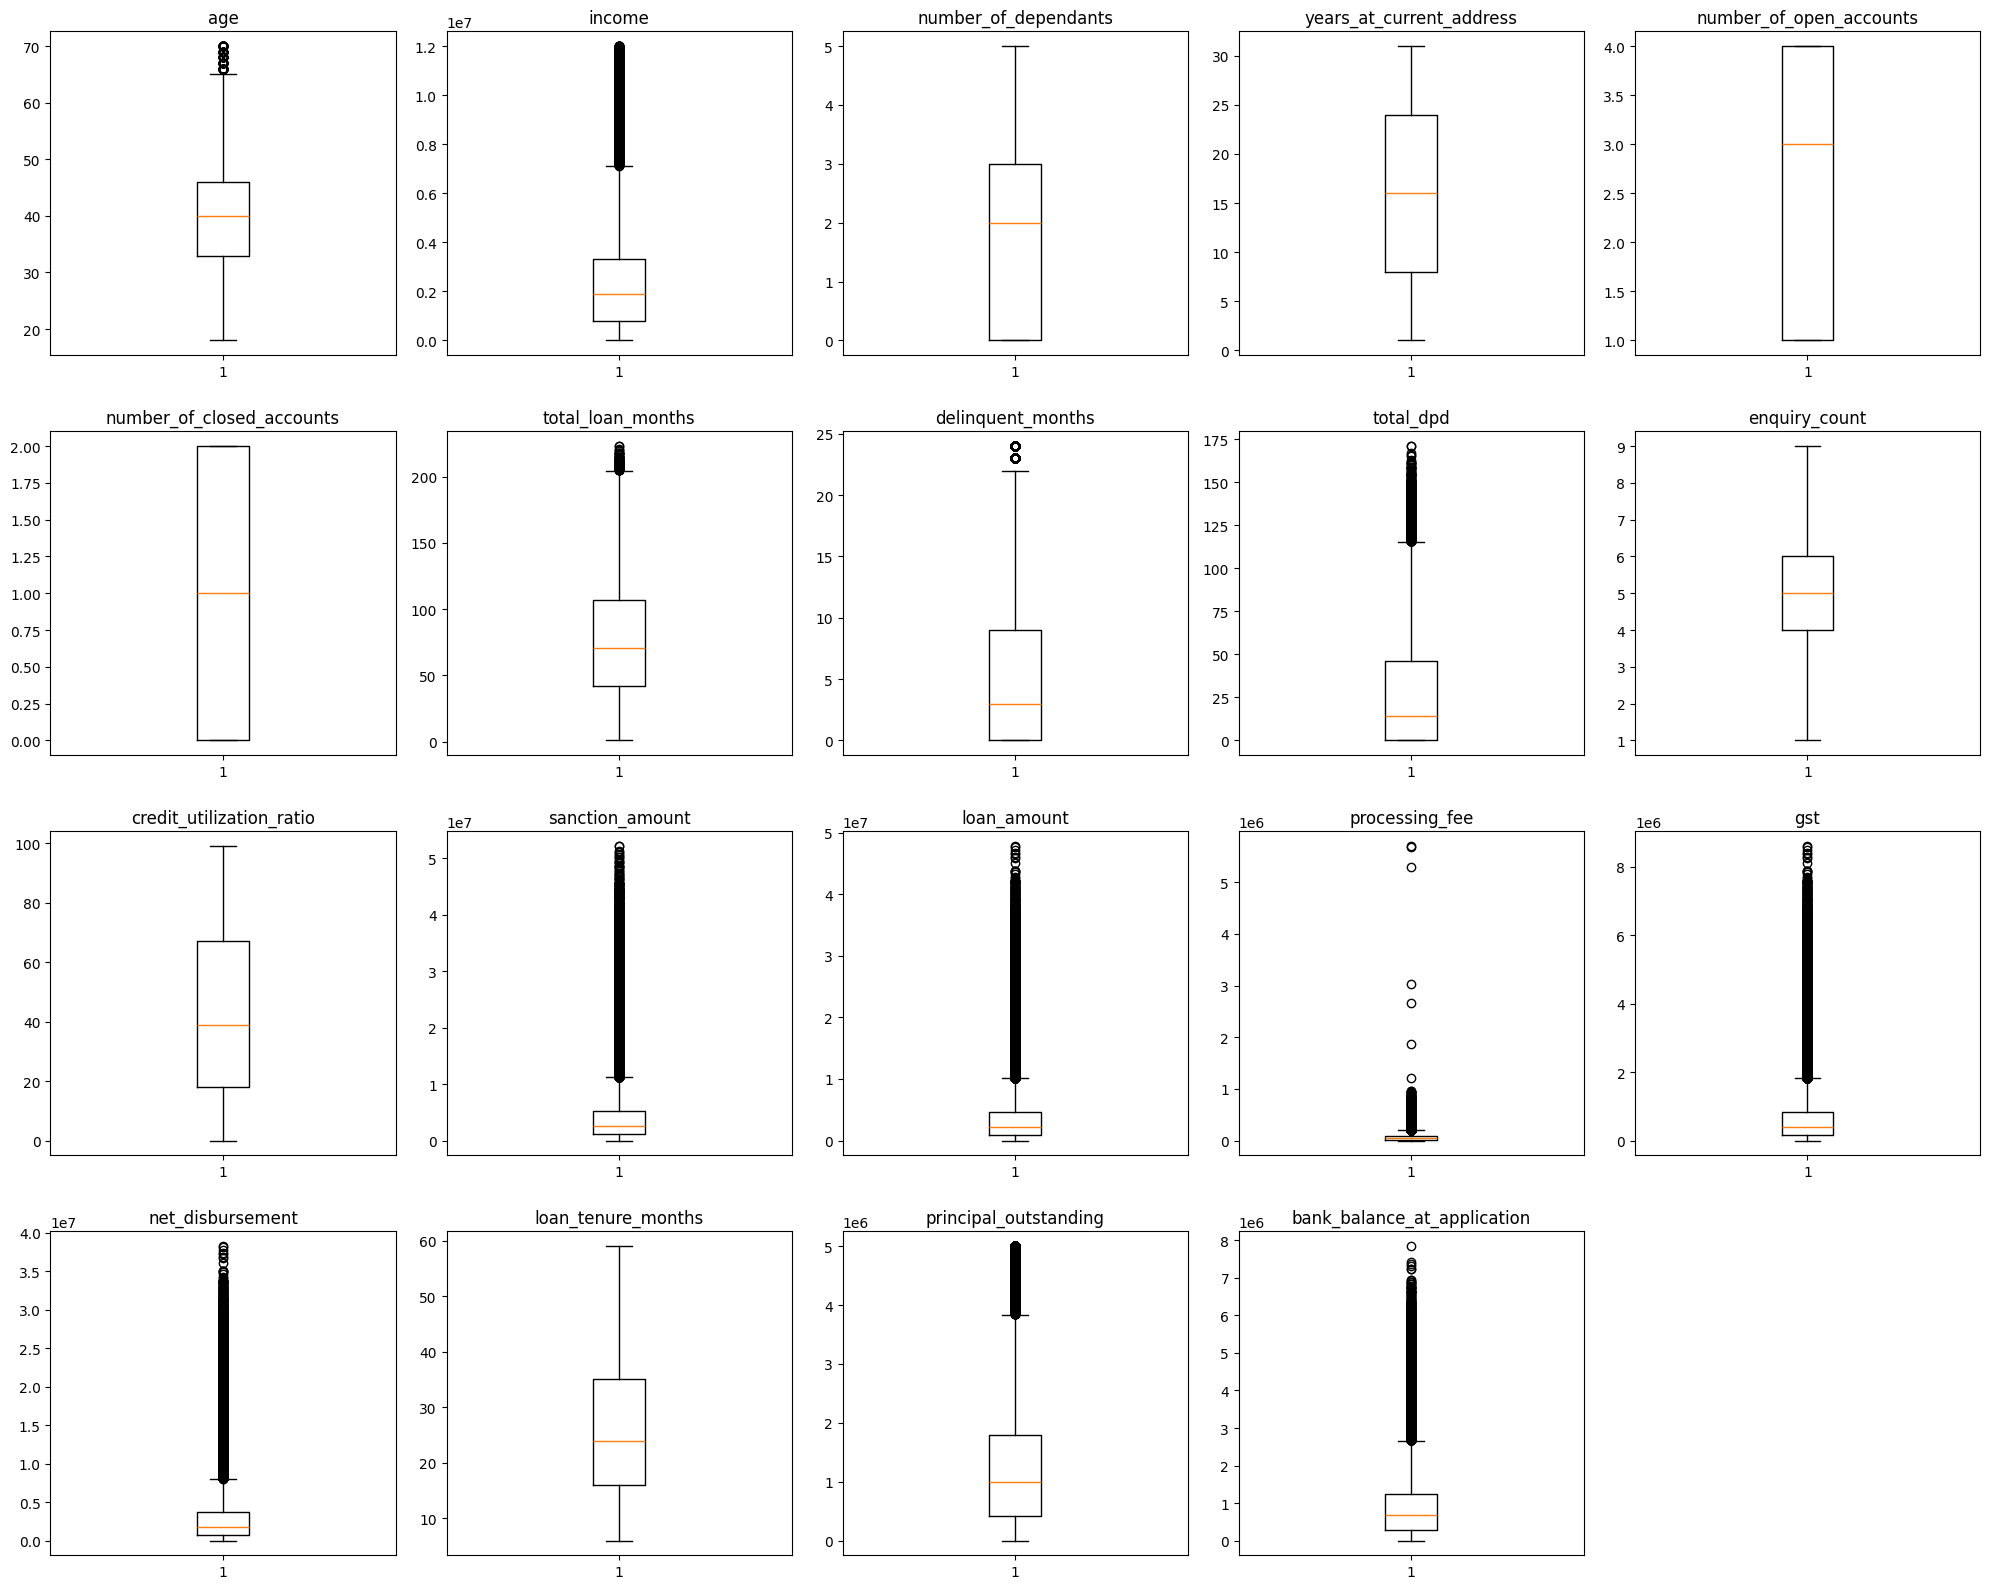

In [5]:
# Grid layout: 4 rows, calculate number of columns needed
n_plots = len(num_cols)
n_rows = 4
n_cols = -(-n_plots // n_rows)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

# Plot each boxplot
for i in range(n_plots):
    col= num_cols[i]
    axes[i].boxplot(df[col])
    axes[i].set_title(col)

# Turn off unused subplots if any
for j in range(n_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

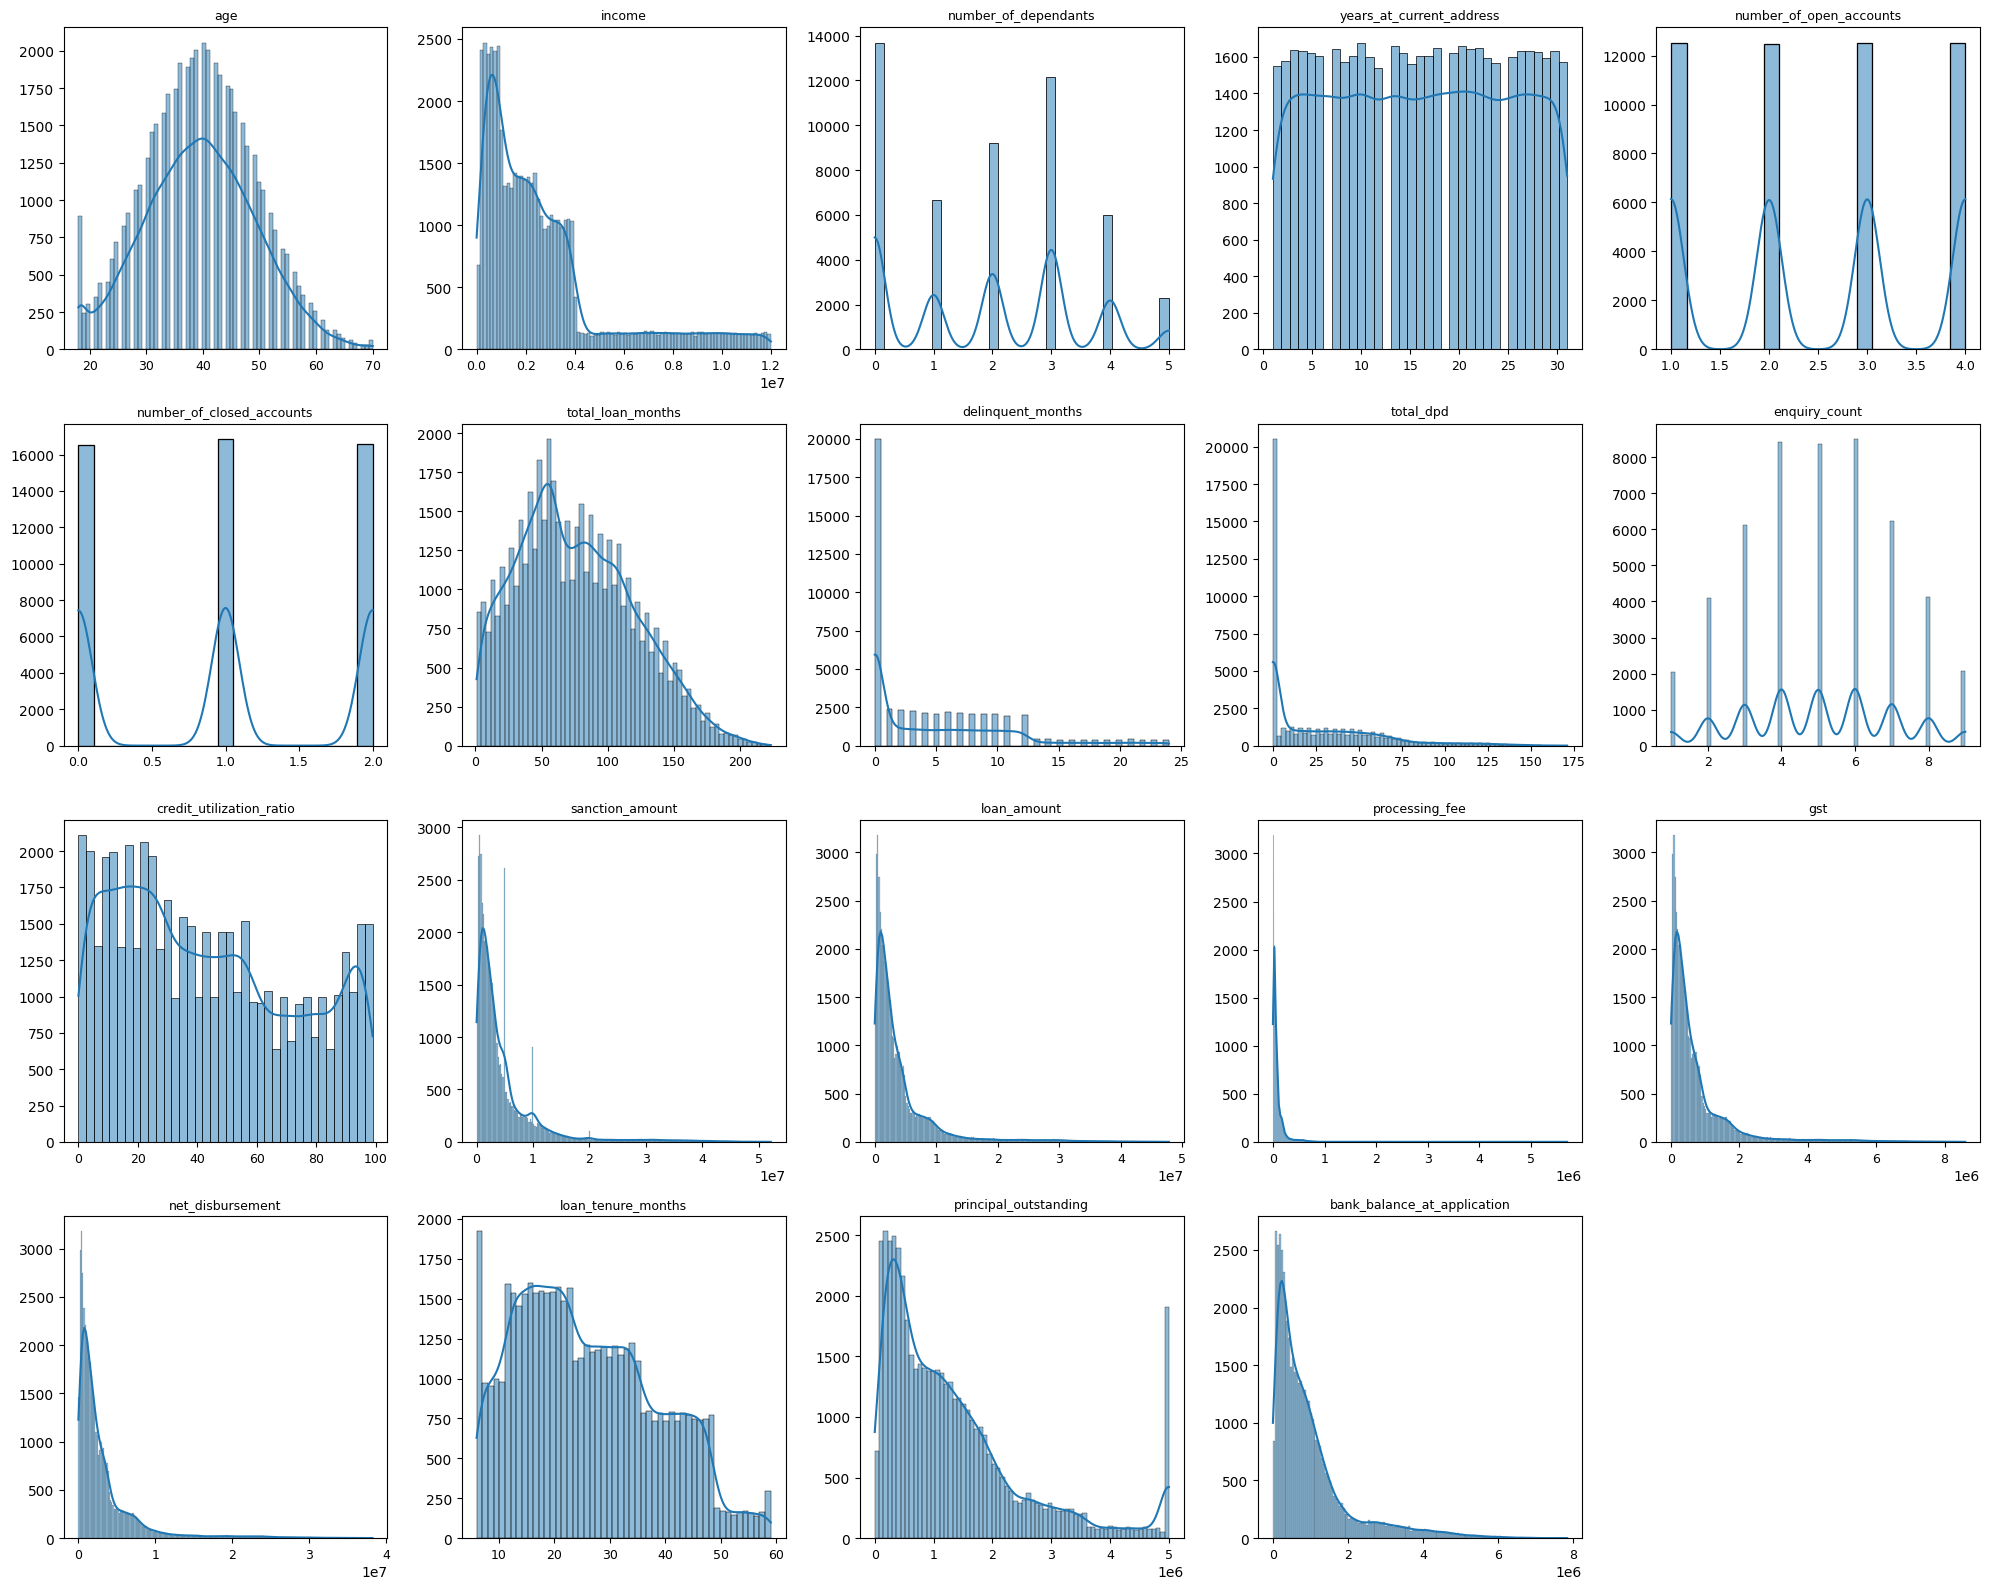

In [6]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

# Plot each boxplot
for i in range(n_plots):
    feature= num_cols[i]
    sns.histplot(
        x= df[feature],
        ax = axes[i],
        kde= True
    )
    axes[i].set_title(feature, fontsize= 9)
    axes[i].tick_params(axis='x', labelsize=9)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Turn off unused subplots if any
for j in range(n_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

From Box plot and KDE plot we can identify processing_fee feature is highly skewed compared to loan_amount, even thou it is processing_fee is calculted by taking a percentage of loan_amount.

In [7]:
# Investigating processing_fee and related columns
df[df['processing_fee'] == df['processing_fee'].max()][['loan_amount', 'processing_fee', 'gst', 'net_disbursement']].astype(int)

,loan_amount,processing_fee,gst,net_disbursement
12294,4639000,5698029,835020,3711200


We can observe that processing_fee > loan_amount and...

In [8]:
# Investigating records where processing_fee > loan_amount
print(f"No. of records where processing_fee > loan_amount : {df[df['processing_fee'] > df['loan_amount']].shape[0]}")
df[df['processing_fee'] > df['loan_amount']][['loan_amount', 'processing_fee', 'gst', 'net_disbursement']].astype(int)

No. of records where processing_fee > loan_amount : 7


,loan_amount,processing_fee,gst,net_disbursement
9898,3626000,5293543,652680,2900800
12294,4639000,5698029,835020,3711200
23981,2234000,2669791,402120,1787200
28174,966000,1214492,173880,772800
29305,2616000,3036378,470880,2092800
33705,3812000,5678020,686160,3049600
47089,1738000,1858964,312840,1390400


...there are 7 such records where this anomaly exists. This could be due to some system error within pipeline.

During the communcation (via Email) with client PoC, they clarified that processing_fee is 3% of loan_amount. Furthemore, they suggested that the rate of GST on services like loan processing and foreclosure charges is uniform at 18%. So we will also validate that as well.

In [9]:
# Investigating records where processing_fee > 3%
print(f"No. of records where processing_fee > 3% : {df[df['processing_fee'] / df['loan_amount'] > 0.03].shape[0]}")
df[df['processing_fee'] / df['loan_amount'] > 0.03][['loan_amount', 'processing_fee', 'gst', 'net_disbursement']].astype(int)

No. of records where processing_fee > 3% : 7


,loan_amount,processing_fee,gst,net_disbursement
9898,3626000,5293543,652680,2900800
12294,4639000,5698029,835020,3711200
23981,2234000,2669791,402120,1787200
28174,966000,1214492,173880,772800
29305,2616000,3036378,470880,2092800
33705,3812000,5678020,686160,3049600
47089,1738000,1858964,312840,1390400


In [10]:
# Investigating records where processing_fee > loan_amount
print(f"No. of records where gst > loan_amount : {df[df['gst'] > df['loan_amount']].shape[0]}")
df[df['gst'] > df['loan_amount']][['loan_amount', 'processing_fee', 'gst', 'net_disbursement']].astype(int)

No. of records where gst > loan_amount : 0


,loan_amount,processing_fee,gst,net_disbursement


In [11]:
# Investigating records where processing_fee > 18%
print(f"No. of records where gst > 18% : {df[df['gst'] / df['loan_amount'] > 0.18].shape[0]}")
df[df['gst'] / df['loan_amount'] > 0.18][['loan_amount', 'processing_fee', 'gst', 'net_disbursement']].astype(int)

No. of records where gst > 18% : 0


,loan_amount,processing_fee,gst,net_disbursement


Lead data scientist suggested that till Data engineers correct pipeline bugs, we can recalculate processing_fee records based on validation rules. This was also communicated to Client PoC and their confirmation was taken.

## Categorical Columns

In [12]:
# Check for distinct values
cat_cols = [
    'gender',
    'marital_status',
    'employment_status',
    'residence_type',
    'city',
    'state',
    'loan_purpose',
    'loan_type',
    'default'
]
for col in cat_cols:
    print(f"{col:<17} : {df[col].unique().tolist()}")

gender            : ['M', 'F']
marital_status    : ['Married', 'Single']
employment_status : ['Self-Employed', 'Salaried']
residence_type    : ['Owned', 'Mortgage', 'Rented', nan]
city              : ['Delhi', 'Chennai', 'Kolkata', 'Bangalore', 'Pune', 'Jaipur', 'Lucknow', 'Mumbai', 'Ahmedabad', 'Hyderabad']
state             : ['Delhi', 'Tamil Nadu', 'West Bengal', 'Karnataka', 'Maharashtra', 'Rajasthan', 'Uttar Pradesh', 'Gujarat', 'Telangana']
loan_purpose      : ['Auto', 'Home', 'Personal', 'Education', 'Personaal']
loan_type         : ['Secured', 'Unsecured']
default           : [False, True]


- loan_purpose has inconsistent categories i.e. 'Personal' & 'Personaal'
- we have to transform datatype of default (target) from bool to int
- residence_type will be imputed

# Data Preparation

## Handling Data Leakage I

In [13]:
# Handling Train Test Contamination

# Split input features and target feature 
X = df.drop(columns= ['default'], axis= 1)
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 69)

# Concat respective input features and target feature 
train = pd.concat([X_train, y_train], axis= 1)
test = pd.concat([X_test, y_test], axis= 1)

# Check for dataframe shape
for split in [train, test]:
    print(f'No. of rows: {split.shape[0]:,}')
    print(f'No. of cols: {split.shape[1]}')
    print("="*30)

No. of rows: 35,000
No. of cols: 33
No. of rows: 15,000
No. of cols: 33


## Data Cleaning

In [14]:
# Handling missing values
resi_type_mode = train['residence_type'].mode()[0]
train['residence_type'] = train['residence_type'].fillna(value= resi_type_mode)
df_mv = pd.DataFrame(data={
    'no. of missing values' : train.isna().sum(),
    '% of missing values' : train.isna().sum() / train.shape[0] * 100
})
print('Missing value details:\n',df_mv[df_mv['no. of missing values'] > 0])
print("="*75)

# Handle duplicate records
train = train.drop_duplicates().copy()
print('No. of duplicate records:',train.duplicated().sum())
print("="*75)

# Handle anomalies
print('No. of records with anomalies:')
train = train[train['principal_outstanding'] != -1].copy()
for col in cols_to_investigate:
    if col == 'principal_outstanding':
        print(f"{col:<27} : {train[train[col] == -1].shape[0]}")
    else:
        print(f"{col:<27} : {train[train[col] == 0].shape[0]}")
print("="*75)

excess_processing_fee_index = train[(train['processing_fee'] / train['loan_amount']) > 0.03].index
train.loc[excess_processing_fee_index, 'processing_fee'] = train.loc[excess_processing_fee_index]['loan_amount'] * 0.03
print(f"No. of records where processing_fee > 3% : {train[(train['processing_fee'] / train['loan_amount']) > 0.03].shape[0]}")
print("="*75)

excess_gst_index = train[(train['gst'] / train['loan_amount']) > 0.18].index
train.loc[excess_gst_index, 'gst'] = train.loc[excess_processing_fee_index]['loan_amount'] * 0.18
print(f"No. of records where gst > 18% : {train[(train['gst'] / train['loan_amount']) > 0.18].shape[0]}")
print("="*75)

# Handling category inconsistency
train['loan_purpose'] = train['loan_purpose'].replace(to_replace= 'Personaal', value= 'Personal')
print(f"{'Distinct values in loan_purpose':<17} : {train['loan_purpose'].unique().tolist()}")
print("="*75)

# Change datatype of default (target)
train['default'] = train['default'].astype(int)
print(f"{'Datatype of default':<17} : {train['default'].dtype}")
print("="*75)

Missing value details:
 Empty DataFrame
Columns: [no. of missing values, % of missing values]
Index: []
No. of duplicate records: 0
No. of records with anomalies:
principal_outstanding       : 0
income                      : 0
sanction_amount             : 0
loan_amount                 : 0
processing_fee              : 0
gst                         : 0
net_disbursement            : 0
bank_balance_at_application : 0
No. of records where processing_fee > 3% : 0
No. of records where gst > 18% : 0
Distinct values in loan_purpose : ['Personal', 'Auto', 'Home', 'Education']
Datatype of default : int64


## Cleaning Test

In [15]:
# Handling missing values
resi_type_mode = test['residence_type'].mode()[0]
test['residence_type'] = test['residence_type'].fillna(value= resi_type_mode)
df_mv = pd.DataFrame(data={
    'no. of missing values' : test.isna().sum(),
    '% of missing values' : test.isna().sum() / test.shape[0] * 100
})
print('Missing value details:\n',df_mv[df_mv['no. of missing values'] > 0])
print("="*75)

# Handle duplicate records
test = test.drop_duplicates().copy()
print('No. of duplicate records:',test.duplicated().sum())
print("="*75)

# Handle anomalies
print('No. of records with anomalies:')
test = test[test['principal_outstanding'] != -1].copy()
for col in cols_to_investigate:
    if col == 'principal_outstanding':
        print(f"{col:<27} : {test[test[col] == -1].shape[0]}")
    else:
        print(f"{col:<27} : {test[test[col] == 0].shape[0]}")
print("="*75)

excess_processing_fee_index = test[(test['processing_fee'] / test['loan_amount']) > 0.03].index
test.loc[excess_processing_fee_index, 'processing_fee'] = test.loc[excess_processing_fee_index]['loan_amount'] * 0.03
print(f"No. of records where processing_fee > 3% : {test[(test['processing_fee'] / test['loan_amount']) > 0.03].shape[0]}")
print("="*75)

excess_gst_index = test[(test['gst'] / test['loan_amount']) > 0.18].index
test.loc[excess_gst_index, 'gst'] = test.loc[excess_processing_fee_index]['loan_amount'] * 0.18
print(f"No. of records where gst > 18% : {test[(test['gst'] / test['loan_amount']) > 0.18].shape[0]}")
print("="*75)

# Handling category inconsistency
test['loan_purpose'] = test['loan_purpose'].replace(to_replace= 'Personaal', value= 'Personal')
print(f"{'Distinct values in loan_purpose':<17} : {test['loan_purpose'].unique().tolist()}")
print("="*75)

# Change datatype of default (target)
test['default'] = test['default'].astype(int)
print(f"{'Datatype of default':<17} : {test['default'].dtype}")
print("="*75)

Missing value details:
 Empty DataFrame
Columns: [no. of missing values, % of missing values]
Index: []
No. of duplicate records: 0
No. of records with anomalies:
principal_outstanding       : 0
income                      : 0
sanction_amount             : 0
loan_amount                 : 0
processing_fee              : 0
gst                         : 0
net_disbursement            : 0
bank_balance_at_application : 0
No. of records where processing_fee > 3% : 0
No. of records where gst > 18% : 0
Distinct values in loan_purpose : ['Personal', 'Home', 'Auto', 'Education']
Datatype of default : int64


# Target Analysis

## Class imbalance

In [16]:
df_imb = pd.DataFrame(data= {
    'feature size': train['default'].value_counts(),
    'pct_size' : train['default'].value_counts() / train.shape[0] * 100
})
df_imb

,feature size,pct_size
default,,
0,31981,91.392564
1,3012,8.607436


There is an obvious imbalance in default because proportion of defaulters is always low.

## Bivariant Analysis

Now, we will split the target and explore their respective distribution to identify distinct patterns indicating predictive powers of all the features.

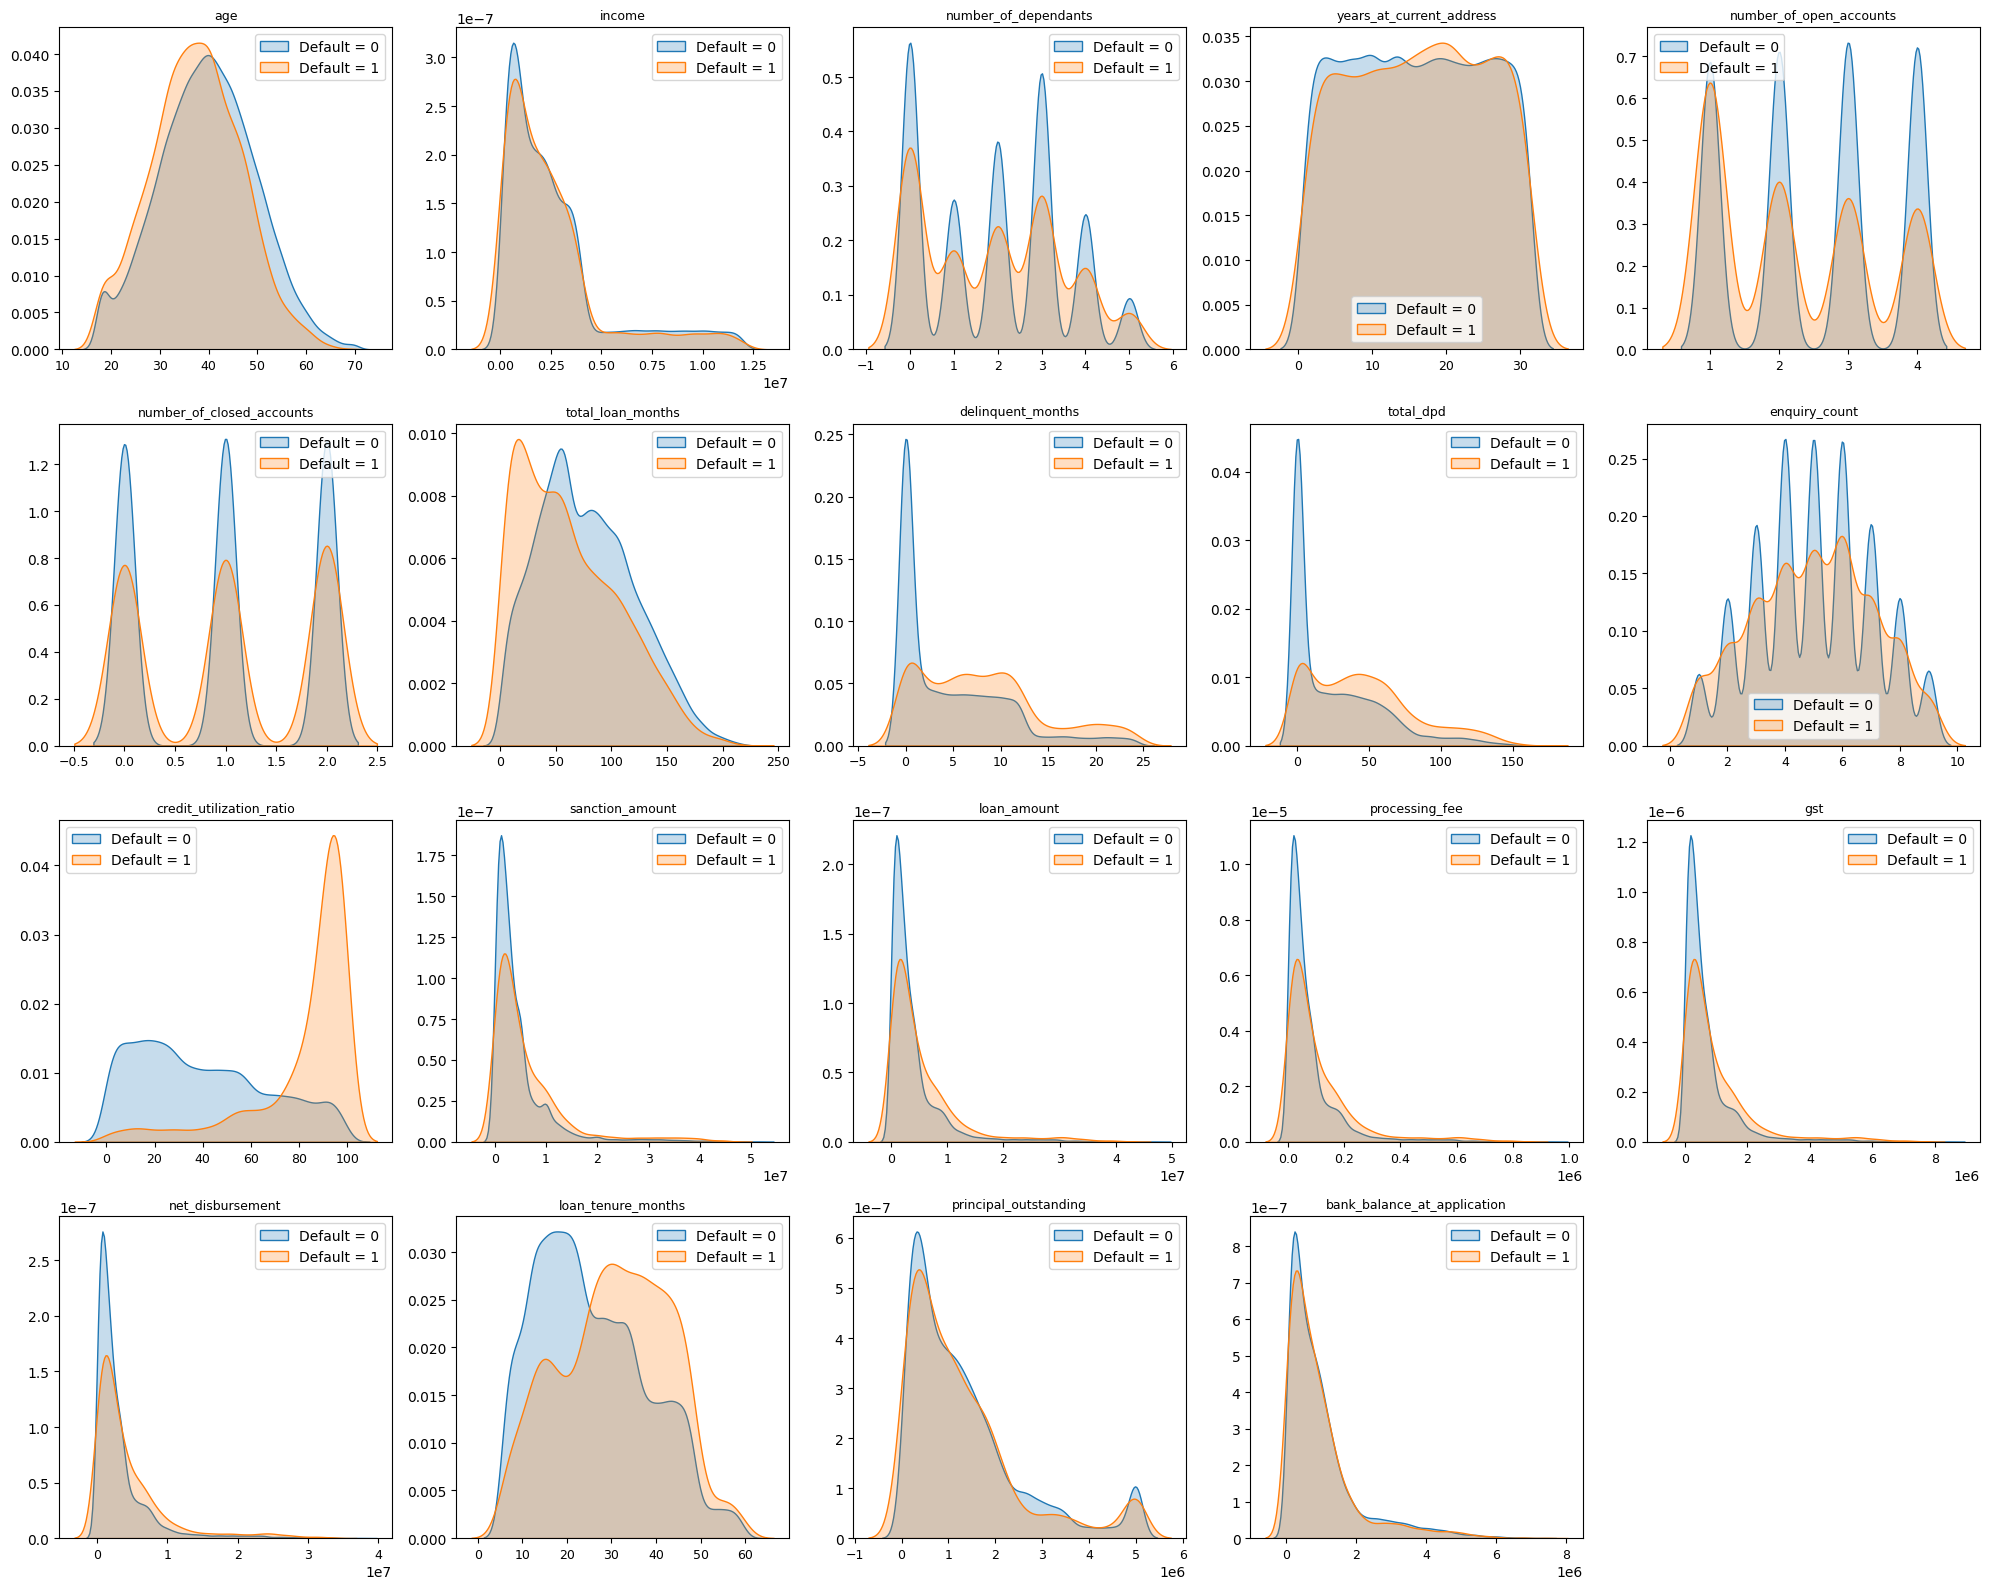

In [17]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

# Plot each boxplot
for i in range(n_plots):
    feature= num_cols[i]
    sns.kdeplot(
        x= train[train['default'] == 0][feature],
        ax = axes[i],
        fill= True,
        label= 'Default = 0'
    )
    sns.kdeplot(
        x= train[train['default'] == 1][feature],
        ax = axes[i],
        fill= True,
        label= 'Default = 1'
    )
    axes[i].set_title(feature, fontsize= 9)
    axes[i].tick_params(axis='x', labelsize=9)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].legend()

# Turn off unused subplots if any
for j in range(n_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Based on the KDE plots, the following features show distinct distribution patterns between defaulters and non-defaulters, indicating their potential predictive power in classifying defaults:

Strong predictors:
1. Total Loan Months
2. Delinquent Months
3. Total DPD
4. Credit Utilization Ratio
5. Loan Tenure (in Months)

Weak Predictors:
1. Age
2. Years at Current Address
3. Number of Total Accounts
4. Enquiry Count

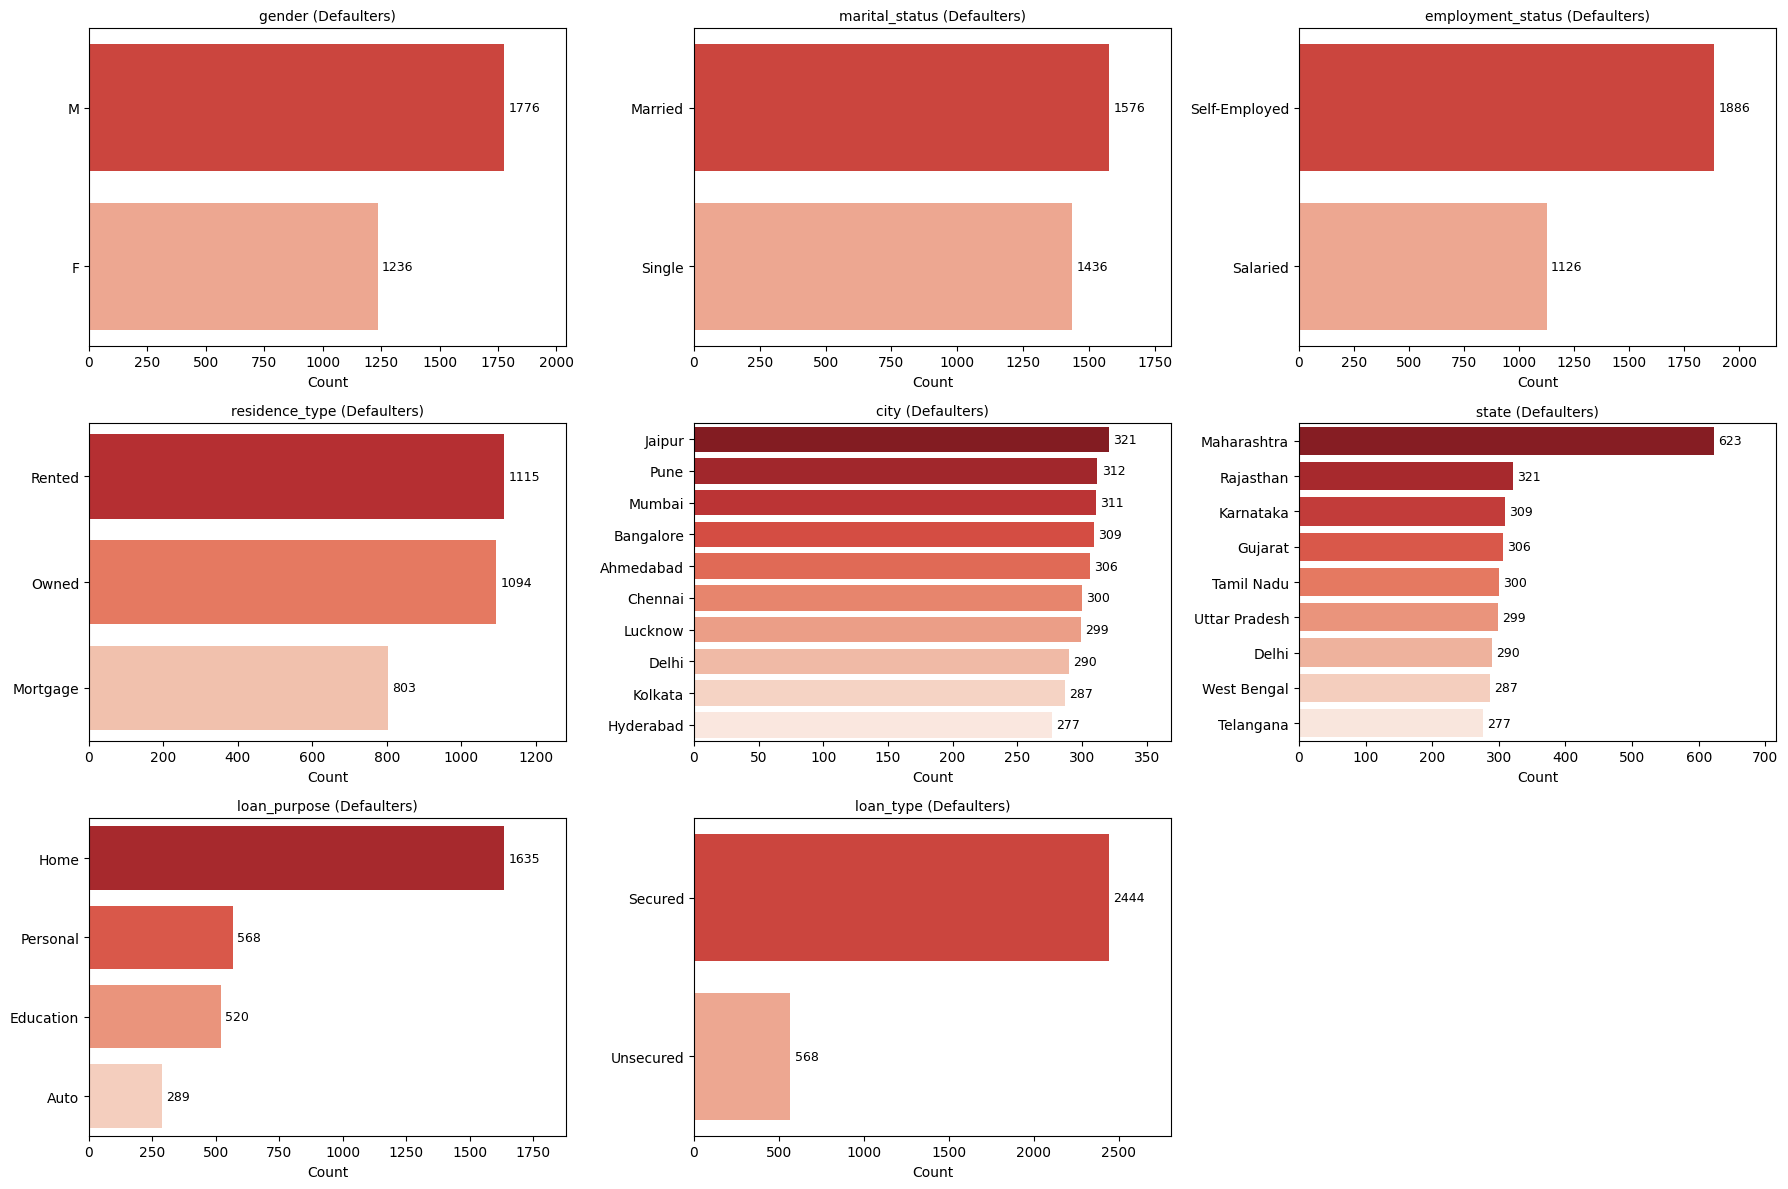

In [18]:
# Remove 'default' from features (it is the target)
cat_features = [col for col in cat_cols if col != 'default']

n_plots = len(cat_features)
n_cols = 3
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
axes = axes.flatten()

for i, feature in enumerate(cat_features):
    df_defaulters = train[train['default'] == 1]

    count_df = df_defaulters[feature].value_counts().reset_index()
    count_df.columns = [feature, 'count']

    sns.barplot(
        data=count_df,
        y=feature,
        x='count',
        hue=feature,
        dodge=False,
        legend=False,
        ax=axes[i],
        palette="Reds_r"
    )

    # Adjust x-axis limit for label visibility
    max_val = count_df['count'].max()
    axes[i].set_xlim(0, max_val * 1.15)   # 15% buffer

    # Add text labels
    for p in axes[i].patches:
        axes[i].text(
            p.get_width() + max_val * 0.01,    # slight offset inside the buffer
            p.get_y() + p.get_height()/2,
            int(p.get_width()),
            va='center', fontsize=9
        )

    axes[i].set_title(f"{feature} (Defaulters)", fontsize=10)
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel("")

# Turn off unused subplots
for j in range(n_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Using Bar plot we have identified following categories in their respective features that might contribute highest to risk associated with defaulters:
1. Male (Gender)
2. Self-employed (Employment Status)
3. Maharashtra (State)
4. Home (Loan purpose)
5. Secured (Loan type)

# Feature Engineering

## Derived Features

Now, we will generate three import ratios using existing features:
- loan to income ratio
- delinquency ratio
- avg. dpd

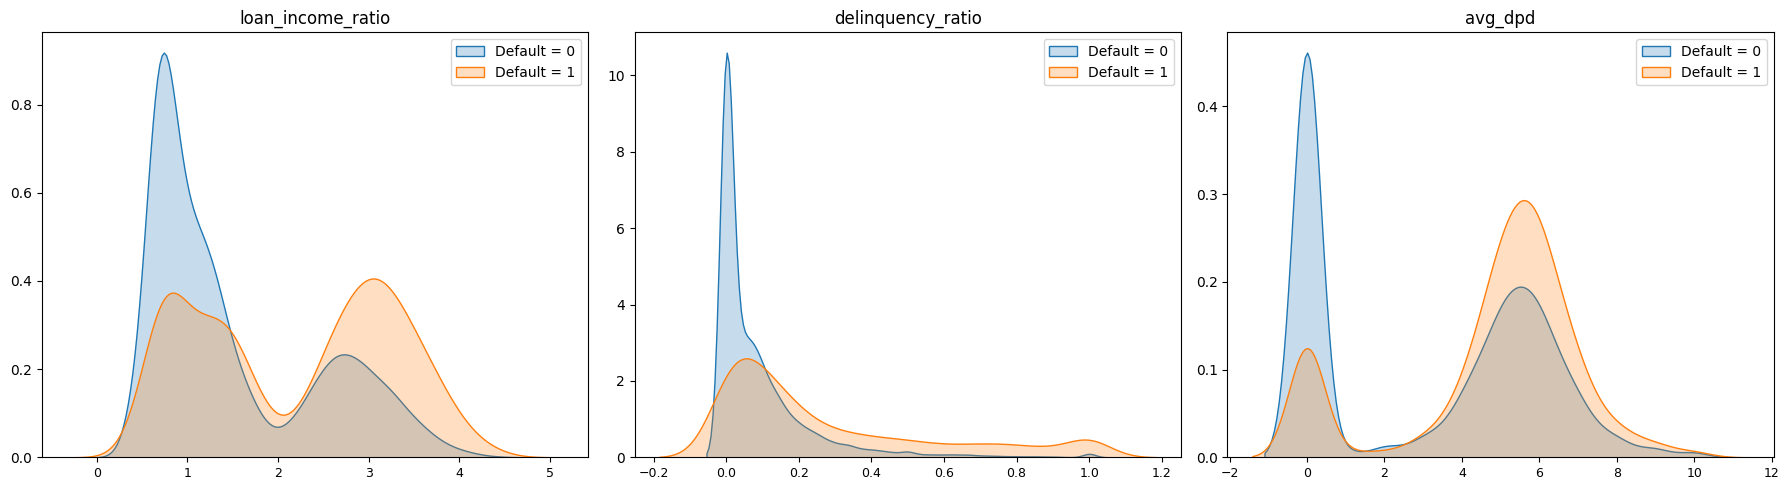

In [19]:
# Generate loan to income ratio
train['loan_income_ratio'] = train['loan_amount'] / train['income']

# Generate delinquency ratio
train['delinquency_ratio'] = (train['delinquent_months'] / train['total_loan_months']).fillna(value= 0)

# Generate avg. dpd
train['avg_dpd'] = (train['total_dpd'] / train['delinquent_months']).fillna(value= 0)

ratios = ['loan_income_ratio', 'delinquency_ratio', 'avg_dpd']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, ratio in enumerate(ratios):
    sns.kdeplot(
        x= train[train['default'] == 0][ratio],
        ax = axes[i],
        fill= True,
        label= 'Default = 0'
    )
    sns.kdeplot(
        x= train[train['default'] == 1][ratio],
        ax = axes[i],
        fill= True,
        label= 'Default = 1'
    )
    axes[i].set_title(ratio, fontsize= 12)
    axes[i].tick_params(axis='x', labelsize=9)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].legend()

# Turn off unused subplots if any
for j in range(n_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Based on KDE plots, we can identify distinct patterns in all three ratios for defaulters and non-defaulters indicating their predictive powers to classify defaulters.

## Feature Selection I

Now, we will manually remove irrelevant features

In [20]:
cols_to_drop = [
    'cust_id',
    'loan_id',
    'disbursal_date',
    'installment_start_dt'
]
train = train.drop(columns= cols_to_drop).copy()

## Handling Data Leaking II

In [21]:
# Handling Target Leakage
X_train = train.drop(columns= ['default'], axis= 1).copy()
y_train = train['default'].copy()

## Feature Scaling

In [22]:
# Updating num_cols list
num_cols.extend(ratios)

# Using normalization to scale
normal_scaler = MinMaxScaler()
X_train[num_cols] = normal_scaler.fit_transform(X=X_train[num_cols])

X_train[num_cols].describe()

,age,income,number_of_dependants,years_at_current_address,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio,sanction_amount,loan_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,loan_income_ratio,delinquency_ratio,avg_dpd
count,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000,34993.000000
mean,0.414452,0.213370,0.387758,0.499199,0.498966,0.502972,0.337402,0.203559,0.157370,0.500543,0.437936,0.088662,0.082356,0.082359,0.082356,0.082356,0.375803,0.261180,0.130695,0.296214,0.103830,0.330720
std,0.188610,0.221040,0.307335,0.297663,0.372482,0.407572,0.196263,0.243431,0.191552,0.253740,0.297256,0.119734,0.112053,0.112053,0.112053,0.112053,0.234941,0.244532,0.141309,0.228906,0.172275,0.290560
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.288462,0.059081,0.000000,0.233333,0.000000,0.000000,0.184685,0.000000,0.000000,0.375000,0.181818,0.020594,0.019011,0.019011,0.019011,0.019011,0.188679,0.077464,0.035864,0.111172,0.000000,0.000000
50%,0.423077,0.150181,0.400000,0.500000,0.666667,0.500000,0.315315,0.125000,0.081871,0.500000,0.393939,0.049594,0.045726,0.045726,0.045726,0.045726,0.339623,0.193032,0.087475,0.203515,0.038462,0.436364
75%,0.538462,0.271956,0.600000,0.766667,0.666667,1.000000,0.472973,0.375000,0.269006,0.625000,0.676768,0.097403,0.095199,0.095199,0.095199,0.095199,0.547170,0.353277,0.164004,0.507601,0.130435,0.575000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Feature Selection II

### Using Variance Inflation Factor

In [23]:
# Defining a VIF function
def cal_vif(x):
    df_vif = pd.DataFrame(
        data = {
        'features' : x.columns,
        'vif' : [round(variance_inflation_factor(exog= x.values, exog_idx= i),4) for i in range(x.shape[1])]
        }
    )
    
    return df_vif

df_vif = cal_vif(X_train[num_cols])

df_vif

C:\Users\LaptopGP\AppData\Roaming\Python\Python313\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,features,vif
0,age,5.7355
1,income,34.8172
2,number_of_dependants,2.7273
3,years_at_current_address,3.3878
4,number_of_open_accounts,8.1942
5,number_of_closed_accounts,2.3901
6,total_loan_months,10.4425
7,delinquent_months,49.6200
8,total_dpd,51.7633
9,enquiry_count,6.3823


In [24]:
# Dropping high VIF columns (one by one)
cols_high_vif = [
    'loan_amount', 
    'processing_fee', 
    'gst', 
    'net_disbursement', 
    'income', 
    'total_loan_months',
    'delinquent_months', 
    'principal_outstanding'
]
df_vif = cal_vif(X_train[num_cols].drop(columns=cols_high_vif))
df_vif

,features,vif
0,age,5.3816
1,number_of_dependants,2.7214
2,years_at_current_address,3.3420
3,number_of_open_accounts,4.4702
4,number_of_closed_accounts,2.3696
5,total_dpd,3.6914
6,enquiry_count,6.3163
7,credit_utilization_ratio,2.8905
8,sanction_amount,4.6351
9,loan_tenure_months,5.9539


In [25]:
# Selecting columns based on VIF
X_train = X_train.drop(columns=cols_high_vif, axis= 1).copy()

### Using Weight of Evidence and Information Value

In [26]:
X_train.head()

,age,gender,marital_status,employment_status,number_of_dependants,residence_type,years_at_current_address,city,state,zipcode,number_of_open_accounts,number_of_closed_accounts,total_dpd,enquiry_count,credit_utilization_ratio,loan_purpose,loan_type,sanction_amount,loan_tenure_months,bank_balance_at_application,loan_income_ratio,delinquency_ratio,avg_dpd
2123,0.365385,F,Married,Salaried,0.8,Rented,0.100000,Bangalore,Karnataka,560001,0.666667,0.5,0.040936,0.625,1.000000,Personal,Unsecured,0.003378,0.075472,0.010846,0.067757,0.026549,0.233333
49548,0.480769,F,Single,Salaried,0.0,Rented,0.300000,Bangalore,Karnataka,560001,0.666667,0.0,0.000000,0.250,0.939394,Auto,Secured,0.010307,0.433962,0.036472,0.166240,0.000000,0.000000
31170,0.634615,M,Married,Self-Employed,0.6,Owned,0.100000,Chennai,Tamil Nadu,600001,0.333333,1.0,0.368421,0.750,0.595960,Auto,Secured,0.006372,0.547170,0.015996,0.132116,0.909091,0.630000
38084,0.576923,M,Married,Self-Employed,0.4,Mortgage,0.433333,Chennai,Tamil Nadu,600001,0.333333,0.0,0.391813,0.750,0.707071,Auto,Secured,0.065754,0.245283,0.194318,0.189243,0.260870,0.558333
27438,0.307692,M,Single,Self-Employed,0.0,Owned,0.966667,Jaipur,Rajasthan,302001,0.666667,1.0,0.327485,0.625,0.949495,Home,Secured,0.015585,0.792453,0.009377,0.749953,0.090909,0.622222


In [27]:
# Updating categorical columns
cat_cols.remove('default')
cat_cols.append('zipcode')

# Defining IV function
def cal_iv(df, feature, target):
    grp = df.groupby(by= feature)[target].agg(func= ['count', 'sum'])
    grp = grp.rename(columns= {
        'count': 'total',
        'sum': 'good'
    })
    grp['bad'] = grp['total'] - grp['good']

    total_good = grp['good'].sum()
    total_bad = grp['bad'].sum()

    grp['pct_good'] = grp['good'] / total_good
    grp['pct_bad'] = grp['bad'] / total_bad

    grp['WoE'] = np.log(grp['pct_good'] / grp['pct_bad'])
    grp['cat_IV'] = grp['WoE'] * (grp['pct_good'] - grp['pct_bad'])

    feature_IV = grp['cat_IV'].sum()

    return feature_IV

# Check for IV
df_iv = pd.DataFrame(data= {
    'features' : cat_cols,
    'IV': [cal_iv(train, col, 'default') for col in cat_cols]
})
df_iv

,features,IV
0,gender,0.000420
1,marital_status,0.003174
2,employment_status,0.001534
3,residence_type,0.247792
4,city,0.001928
5,state,0.001857
6,loan_purpose,0.384867
7,loan_type,0.162473
8,zipcode,0.001928


In [28]:
# Dropping columns with weak predictors
low_iv_cols = df_iv[df_iv['IV'] <= 0.02]['features'].to_list()

X_train = X_train.drop(columns=low_iv_cols, axis= 1).copy()

## Feature Encoding

In [29]:
# One hot encoding
cols_to_encode = df_iv[df_iv['IV'] > 0.02]['features'].to_list()

X_train = pd.get_dummies(data= X_train, columns= cols_to_encode, dtype= 'int64', drop_first= True)
X_train.head()

,age,number_of_dependants,years_at_current_address,number_of_open_accounts,number_of_closed_accounts,total_dpd,enquiry_count,credit_utilization_ratio,sanction_amount,loan_tenure_months,bank_balance_at_application,loan_income_ratio,delinquency_ratio,avg_dpd,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
2123,0.365385,0.8,0.100000,0.666667,0.5,0.040936,0.625,1.000000,0.003378,0.075472,0.010846,0.067757,0.026549,0.233333,0,1,0,0,1,1
49548,0.480769,0.0,0.300000,0.666667,0.0,0.000000,0.250,0.939394,0.010307,0.433962,0.036472,0.166240,0.000000,0.000000,0,1,0,0,0,0
31170,0.634615,0.6,0.100000,0.333333,1.0,0.368421,0.750,0.595960,0.006372,0.547170,0.015996,0.132116,0.909091,0.630000,1,0,0,0,0,0
38084,0.576923,0.4,0.433333,0.333333,0.0,0.391813,0.750,0.707071,0.065754,0.245283,0.194318,0.189243,0.260870,0.558333,0,0,0,0,0,0
27438,0.307692,0.0,0.966667,0.666667,1.0,0.327485,0.625,0.949495,0.015585,0.792453,0.009377,0.749953,0.090909,0.622222,1,0,0,1,0,0


## Engineering Test

In [30]:
# Generate ratios
test['loan_income_ratio'] = test['loan_amount'] / test['income']
test['delinquency_ratio'] = (test['delinquent_months'] / test['total_loan_months']).fillna(value= 0)
test['avg_dpd'] = (test['total_dpd'] / test['delinquent_months']).fillna(value= 0)

# Manually dropping columns
test = test.drop(columns= cols_to_drop).copy()

# Handling Target Leakage
X_test = test.drop(columns= ['default'], axis= 1).copy()
y_test = test['default'].copy()

# Using normalization to scale
X_test[num_cols] = normal_scaler.transform(X=X_test[num_cols])

# Dropping high VIF columns# 
X_test = X_test.drop(columns=cols_high_vif, axis= 1).copy()

# Dropping columns with weak predictors
X_test = X_test.drop(columns=low_iv_cols, axis= 1).copy()

# One hot encoding
X_test = pd.get_dummies(data= X_test, columns= cols_to_encode, dtype= 'int64', drop_first= True)
X_test.head()

,age,number_of_dependants,years_at_current_address,number_of_open_accounts,number_of_closed_accounts,total_dpd,enquiry_count,credit_utilization_ratio,sanction_amount,loan_tenure_months,bank_balance_at_application,loan_income_ratio,delinquency_ratio,avg_dpd,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
20057,0.634615,0.2,0.033333,0.333333,0.5,0.000000,0.250,0.929293,0.091204,0.075472,0.480710,0.054856,0.000000,0.000000,1,0,0,0,1,1
30147,0.653846,0.2,0.800000,0.666667,1.0,0.000000,0.375,0.535354,0.078057,0.377358,0.120658,0.519339,0.000000,0.000000,0,0,0,1,0,0
17399,0.500000,0.0,0.566667,0.333333,1.0,0.350877,0.375,0.080808,0.121375,0.377358,0.063360,0.521632,0.200000,0.600000,1,0,0,1,0,0
48629,0.596154,0.6,0.833333,1.000000,0.5,0.187135,0.750,0.717172,0.081454,0.415094,0.167598,0.126487,0.057377,0.457143,0,1,0,0,0,0
25554,0.596154,0.6,0.366667,0.000000,0.0,0.087719,0.625,0.959596,0.081665,0.433962,0.148373,0.143909,0.085714,0.500000,0,1,0,0,0,0


## Identifying proxy columns

In [31]:
print('Columns to proxy for scaling:')
for col in num_cols:
    if col not in X_train.select_dtypes([int, float]).columns:
        print(f'✅ {col}')
    else:
        print(f'❌ {col}')

proxy_cols = [col for col in num_cols if col not in X_train.select_dtypes([int, float]).columns]

Columns to proxy for scaling:
❌ age
✅ income
❌ number_of_dependants
❌ years_at_current_address
❌ number_of_open_accounts
❌ number_of_closed_accounts
✅ total_loan_months
✅ delinquent_months
❌ total_dpd
❌ enquiry_count
❌ credit_utilization_ratio
❌ sanction_amount
✅ loan_amount
✅ processing_fee
✅ gst
✅ net_disbursement
❌ loan_tenure_months
✅ principal_outstanding
❌ bank_balance_at_application
❌ loan_income_ratio
❌ delinquency_ratio
❌ avg_dpd


# Exporting Processed Data

In [32]:
# Exporting scaler object
scaler_obj = {
    'scaler' : normal_scaler,
    'cols_to_scale' : num_cols,
    'cols_to_proxy' : proxy_cols
}

dump(
    value= scaler_obj, 
    filename= 'D:/[01] SKILLS/[00] Projects/02 Probability of Default (PD) Model/model/scaler_obj.joblib'
)

# Exporting Train
X_train.to_excel(
    'D:/[01] SKILLS/[00] Projects/02 Probability of Default (PD) Model/data/processed/X_train.xlsx', 
    index= False
)
y_train.to_excel(
    'D:/[01] SKILLS/[00] Projects/02 Probability of Default (PD) Model/data/processed/y_train.xlsx', 
    index= False
)

# Exporting Test
X_test.to_excel(
    'D:/[01] SKILLS/[00] Projects/02 Probability of Default (PD) Model/data/processed/X_test.xlsx', 
    index= False
)
y_test.to_excel(
    'D:/[01] SKILLS/[00] Projects/02 Probability of Default (PD) Model/data/processed/y_test.xlsx', 
    index= False
)